In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

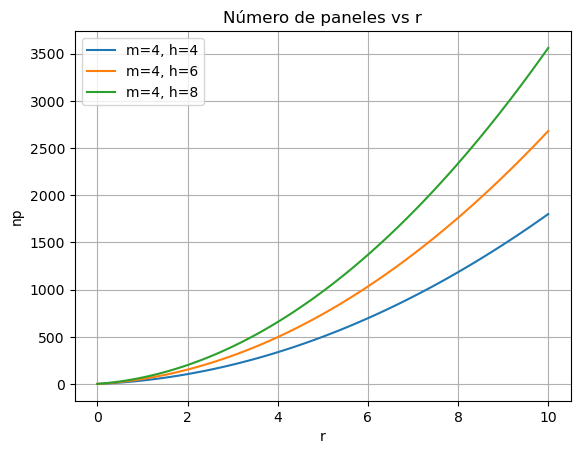

In [2]:
m_values = [4, 4, 4]  # Values of m
h_values = [4, 6, 8]  # Values of h

# Plot for each combination of m and h
for m, h in zip(m_values, h_values):
    def numberp(r):
        return m*(h*r**2+h*r+r)+1

    r_values = np.linspace(0, 10, 100)  # Generate 100 values between 0 and 10
    np_values = numberp(r_values)  # Calculate np values for each r value

    plt.plot(r_values, np_values, label=f'm={m}, h={h}')  # Add label with m and h values

plt.xlabel('r')
plt.ylabel('np')
plt.title('Número de paneles vs r')
plt.grid(True)
plt.legend()  # Add legend to show labels
plt.show()

In [3]:
#definir variables
m=4
delta=np.pi/3.7
alpha=np.pi/2-np.pi/m
epsilon=np.pi/36
eta=(np.pi/m)-(epsilon/2) #igual a delta_planar

In [4]:
def Rm(k):
    angle = 2*(np.pi/m)*k
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
    return rotation_matrix

In [5]:
def det(x,y):
    return x[0]*y[1]-x[1]*y[0]

In [6]:
def lineint(a1,d1,a2,d2):
    return a1+(d1*(det((a2-a1),d2)/det(d1,d2)))

In [7]:
def theta(i,j):
    return (np.pi-delta-alpha)+i*epsilon+2*np.pi*j/m

In [8]:
def phi(i,j):
    return (-delta) + i*epsilon + (2*np.pi*j)/m

In [9]:
print(np.rad2deg(phi(4,1)))

61.35135135135136


In [10]:
def u(x):
    return np.array([np.cos(x),np.sin(x)])

In [11]:
p00 = np.array([1,0])

def p(i,j):
   #j wrap around 
    j=j%m
    if j==0:
        if i==0:
            return p00 
        else:
            return lineint(p(i-1,0),u(theta(i-1,0)),p(i-1,1),u(phi(i-1,1)))
    
    else:
        return Rm(j)@p(i,0)


In [12]:
def dk(h):
    #distancia a la cual hay que ubicar el vértice de la V que comienza un pliegue reverso
    return h*np.cos(epsilon/2)*(np.sqrt(1/np.sin(np.pi/m)*1/np.sin(np.pi/m-epsilon)))

In [13]:
def module_p(i, j):
    p_ij = p(i, j)
    module = np.linalg.norm(p_ij)
    return module

module = module_p(1,0)
print(module)

2.288632017169102


In [14]:
def r_constante(i, j, h):
    p_ij = p(i, j)
    module = module_p(i, j)
    distance = dk(h)
    new_p = distance - module
    return new_p

In [15]:
def rho(i,j,k):
    return theta(i,j)+ eta+ k*epsilon

In [16]:
def sigma(i,j,k):
    return theta(i,j)- eta+ k*epsilon

In [17]:
r_table = np.full((24, 24, 24, 2), np.nan)
def r_punto(i,j,k):
    global r_table 
    j=j%m
    if np.isnan(r_table[i,j,k,0]):
        if k==0:
            r_table[i,j,k]=p(i,j)
            return r_table[i,j,k]
        else:
            r_table[i,j,k]= lineint(r_punto(i,j,k-1),u(rho(i,j,k-1)),p(i+k-1,j+1),u(phi(i+k-1,j+1)))
            #r_table[i,j,k]= lineint(r_punto(i,j,k-1),u(rho(i,j,k-1)),r_punto(i-1,j,k+1),u(phi(i+k-1,j+1)))
            return r_table[i,j,k]
    else:
        return r_table[i,j,k]

In [18]:
s_table = np.full((24, 24, 24, 2), np.nan)
def s(i,j,k):
    global s_table
    j=j%m 
    if np.isnan(s_table[i,j,k,0]):
        if k==0:
            #append in table p(i,j) and return
            s_table[i,j,k] = p(i,j)
            return s_table[i,j,k]

        else:
            s_table[i,j,k] = lineint(s(i,j,k-1),u(sigma(i,j,k-1)),p(i+k,j),u(phi(i+k,j)))
            return s_table[i,j,k]
    else:
        return s_table[i,j,k]


In [19]:
def r_orden(i, j, k,orden): ##TODO: funcion de prueba
    j = j % m
    if i%orden==0:
        if k == 0:
                return p(i, j)
        else:
                #print(r_orden(i,j,k-1,orden))
                return lineint(r_orden(i,j,k-1,orden),u(rho(i,j,k-1)),p(i+k-1,j+1),u(phi(i+k-1,j+1)))

In [20]:
def s_orden(i, j, k, orden): ##TODO: funcion de prueba
    j = j % m
    if k == 0:
            return p(i*orden, j)
    else:
          return lineint(s_orden(i,j,k-1,orden),u(sigma(i,j,k-1)),p(i+k,j),u(phi(i+k,j)))
            

In [21]:
def calculate_centroid(points):
    return np.mean(points, axis=0)

In [22]:
def ajustar_circunferencia(puntos):
    #matriz de diseño
    A = np.array([puntos[:,0], puntos[:,1], np.ones(len(puntos))]).T
    B = np.array([puntos[:,0]**2+puntos[:,1]**2]).T
    #minimos cuadrados
    x = np.linalg.lstsq(A,B,rcond=None)[0]
    #centro y radio
    xc, yc, r = 0.5*x[0], 0.5*x[1], np.sqrt(0.25*x[1]**2+x[2])
    return xc, yc, r

In [23]:
def plot_circle(ax, xc, yc, r):
    theta = np.linspace(0, 2*np.pi, 100)
    x = xc + r*np.cos(theta)
    y = yc + r*np.sin(theta)
    ax.plot(x, y, 'r')